### Natural Language Processing Script

This script can be used as a standalone program to process and prepare topic modelling of the ```Scraper.py``` datasets generated.

### 1.0 <u>Code:</u>

Here, we import the libraries required to run the script.

In [1]:
'''Natural Language toolkit. Here we download the commonly used English stopwords'''
import nltk; nltk.download('stopwords')
'''Standard set of functions for reading and appending files'''
import re
'''Pandas and numpy is a dependency used by other portions of the code.'''
import numpy as np
import pandas as pd
'''Think this stands for pretty print. Prints out stuff to the terminal in a prettier way'''
from pprint import pprint

'''Contains the language model that has to be developed.'''
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
'''Industrial level toolkit for NLP'''
import spacy

'''Importing OS here to build the directories to hold the status logger logs'''
import os

import pyLDAvis
import pyLDAvis.gensim

'''Importing datetime here to log the time when specfic functions are triggered'''
from datetime import datetime

'''Make pretty visualizations'''
import matplotlib.pyplot as plt

'''Library to log any errors. Came across this in the tutorial.'''
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'com', 'https', 'url', 'link', 'abstract', 'author', 'chapter', 'springer', 'title', "the", "of", "and", "in", "to", "a", "is", "for", "from", "with", "that", "by", "are", "on", "was", "as", "were", "url:", "abstract:", "abstract",  "author:", "title:", "at", "be", "an", "have", "this", "which", "been", "not", "has", "its", "also", "these", "this", "can", "a", 'it', 'their', "e.g.", "those", "had", "but", "while", "will", "when", "only", "author", "title", "there", "our", "did", "as", "if", "they", "such", "than", "no", "-", "could"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sarthak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defining the abstracts log name that will be processed by the rest of the script. The status logger function of the main script has been imported here, and the name of the ```.txt``` file used to log the information has to be added here.

In [2]:
abstracts_log_name = "~/projects/Bias/BackUp_Journal_LOGS/Barbara_Data/Barbara_12_Data/Barbara_ANALYTICAL_Complete/BarbaraData_ANALYTICAL_Complete"
session_folder_name = abstracts_log_name.split('/')[-1]
os.makedirs(session_folder_name)
status_logger_name = session_folder_name+"/"+"Status_Logger"+"_"+abstracts_log_name.split('/')[-1]

This function is responsible for generating a ```.txt``` file for analysis once the code has run. This code has been copied directly from the ```common_functions.py``` script of the main code.

In [3]:
def status_logger(status_logger_name, status_key):
	'''Status logger to print and log details throught the running the program.
	Declaring current_hour, current_minute & current_second.'''
	current_hour = str(datetime.now().time().hour)
	current_minute = str(datetime.now().time().minute)
	current_second = str(datetime.now().time().second)
	'''Logging the complete_status_key and printing the complete_status_key'''
	complete_status_key = "[INFO]"+current_hour+":"+current_minute+":"+current_second+" "+status_key
	print(complete_status_key)
	status_log = open(status_logger_name+'.txt', 'a')
	status_log.write(complete_status_key+"\n")
	status_log.close()

Here, we read the ```.txt``` file generated from the journal scrapping, that has to be profiled using topic models.

In [4]:
def data_reader(abstracts_log_name, status_logger_name):
	data_reader_start_status_key = abstracts_log_name+".txt is being ported to dataframe"
	status_logger(status_logger_name, data_reader_start_status_key)
	textual_dataframe = pd.read_csv(abstracts_log_name+'.txt', delimiter="\t")
	data_reader_end_status_key = abstracts_log_name+".txt has been ported to dataframe"	
	status_logger(status_logger_name, data_reader_end_status_key)
	return textual_dataframe

Taking the abstracts and preparing a list of abstracts.

In [5]:
def textual_data_trimmer(textual_dataframe, status_logger_name):
	textual_data_trimmer_start_status_key = "Trimming data and preparing list of words"
	status_logger(status_logger_name, textual_data_trimmer_start_status_key)

	'''This function converts the textual data into a list and removes special characters, virtue of email correspondence'''
	textual_data = textual_dataframe.values.tolist()
	print(textual_data)

	textual_data_trimmer_end_status_key = "Trimmed data and prepared list of words"
	status_logger(status_logger_name, textual_data_trimmer_end_status_key)
	return textual_data

Tokenizing the words here and also removing punctuations from the corpus.

In [6]:
def sent_to_words(textual_data, status_logger_name):
	sent_to_words_start_status_key = "Tokenizing words"
	status_logger(status_logger_name, sent_to_words_start_status_key)
	'''This function tokenizes each sentence into individual words; also called tokens'''
	for sentence in textual_data:
		yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
	textual_data = list(sent_to_words(textual_data))
	sent_to_words_end_status_key = "Tokenized words"
	status_logger(status_logger_name, sent_to_words_end_status_key)	
	return textual_data

Generating ***```bigrams```*** from the ```textual_data``` that we have prepared from the abstracts. **Bigrams** are words that occur together, multiple times in a given body of text. For example, *torrential* and *rain* occur together more often with each other, as opposed to other adjective-noun pairs. Hence the two would form a bigram here.

In [7]:
def bigram_generator(textual_data, status_logger_name):
	bigram_generator_start_status_key = "Generating word bigrams"
	status_logger(status_logger_name, bigram_generator_start_status_key)	
	'''Takes the textual data and prepares the bigram, two collectively high frequency words'''
	bigram = gensim.models.Phrases(textual_data, min_count=5, threshold=100)
	bigram_mod = gensim.models.phrases.Phraser(bigram)
	bigram_generator_end_status_key = "Generated word bigrams"
	status_logger(status_logger_name, bigram_generator_end_status_key)	
	return bigram_mod

Here, we use the ```bigram_mod``` model to generate bigrams from our ```corpus```.

In [8]:
def make_bigrams(textual_data, status_logger_name):
	'''Generates multiple bigrams of word pairs in phrases that commonly occuring with each other over the corpus'''
	make_bigrams_start_status_key = "Generating bigrams"
	status_logger(status_logger_name, make_bigrams_start_status_key)

	bigram_mod = bigram_generator(textual_data, status_logger_name)
	return [bigram_mod[doc] for doc in textual_data]

	make_bigrams_end_status_key = "Generated bigrams"

We remove the stopwords, as specified in a list at the start of the program. There's a marked improvement in the topics and keywords produced after expanding the cache of the words to be filtered out.

In [9]:
def remove_stopwords(textual_data, status_logger_name):
	'''This function removes the standard set of stopwords from the corpus of abstract words'''
	remove_stopwords_start_status_key = "Removing stopwords"
	status_logger(status_logger_name, remove_stopwords_start_status_key)
	return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in textual_data]
	remove_stopwords_end_status_key = "Removed stopwords"
	status_logger(status_logger_name, remove_stopwords_end_status_key)

Generating the ```pyLDAvis``` visualization from the ```lda_model``` generated and trained on our ```corpus``` & ```id2word``` dictionary. The time taken here is proportional to the size of the ```corpus```.

In [10]:
def visualizer_generator(lda_model, corpus, id2word, logs_folder_name, status_logger_name):
	'''This code generates the .html file with generates the visualization of the data prepared.'''
	visualizer_generator_start_status_key = "Preparing the topic modeling visualization"
	status_logger(status_logger_name, visualizer_generator_start_status_key)
    
	textual_data_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
	pyLDAvis.save_html(textual_data_visualization, session_folder_name+'/'+"Data_Visualization_Topic_Modelling.html")

	visualizer_generator_end_status_key = "Prepared the topic modeling visualization"+" "+"Data_Visualization_Topic_Modelling.html"
	status_logger(status_logger_name, visualizer_generator_end_status_key)

Lemmatization involves truncating a term to its root term. For example *running -> run* is an example of the ```lemmatization``` process.

In [11]:
def lemmatization(status_logger_name, textual_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
	lemmatization_start_status_key = "Beginning lemmatization"
	status_logger(status_logger_name, lemmatization_start_status_key)
	"""https://spacy.io/api/annotation"""
	texts_out = []
	nlp = spacy.load('en', disable=['parser', 'ner'])
	for sent in textual_data:
		doc = nlp(" ".join(sent))
		texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
	lemmatization_end_status_key = "Ending lemmatization"
	status_logger(status_logger_name, lemmatization_end_status_key)
	return texts_out

Calling the ```nlp_engine_main()``` function where all the previously defined functions come together and generate the ```pyLDAvis``` visualization for topic analysis.

In [12]:
num_topics = 12

nlp_engine_main_start_status_key = "Initiating the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_start_status_key)

'''Extracts the data from the .txt file and puts them into a Pandas dataframe buckets'''
textual_dataframe = data_reader(abstracts_log_name, status_logger_name)
'''Rids the symbols and special characters from the textual_data'''
textual_data = textual_data_trimmer(textual_dataframe, status_logger_name)
'''Removes stopwords that were earlier downloaded from the textual_data'''
textual_data_no_stops = remove_stopwords(textual_data, status_logger_name)
'''Prepares bigrams'''
textual_data_words_bigrams = make_bigrams(textual_data_no_stops, status_logger_name)
'''Loads the English model from spaCy'''
nlp = spacy.load('en', disable=['parser', 'ner'])

textual_data_lemmatized = lemmatization(status_logger_name, textual_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

id2word = corpora.Dictionary(textual_data_lemmatized)

texts = textual_data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

'''Builds the actual LDA model that will be used for the visualization and inference'''
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = num_topics, random_state = 100, update_every = 1, chunksize = 100, passes = 10, alpha = 'symmetric', per_word_topics = True)

doc_lda = lda_model[corpus]

perplexity_score = lda_model.log_perplexity(corpus)

perplexity_status_key = "Issued perplexity:"+" "+str(perplexity_score)

status_logger(status_logger_name, perplexity_status_key)

nlp_engine_main_end_status_key = "Idling the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_end_status_key)

[INFO]12:48:58 Initiating the NLP Engine
[INFO]12:48:58 ~/projects/Bias/BackUp_Journal_LOGS/Barbara_Data/Barbara_12_Data/Barbara_ANALYTICAL_Complete/BarbaraData_ANALYTICAL_Complete.txt is being ported to dataframe
[INFO]12:48:58 ~/projects/Bias/BackUp_Journal_LOGS/Barbara_Data/Barbara_12_Data/Barbara_ANALYTICAL_Complete/BarbaraData_ANALYTICAL_Complete.txt has been ported to dataframe
[INFO]12:48:58 Trimming data and preparing list of words
[['A seasonal rodent-borne disease surveillance program was established at Dagmar North Training Area located near the demilitarized zone, Republic of Korea, from 2001 through 2005. Selected habitats surveyed included earthen banks separating rice paddies, fighting positions along a 5 m rock-faced earthen berm, and extensive tall grasses with various degrees of herbaceous and scrub vegetation associated with dirt roads, rice paddies, ditches, ponds, or the Imjin River. Of the nine species of small mammals captured, the striped field mouse (Apodemus a

[INFO]12:48:58 Generating bigrams
[INFO]12:48:58 Generating word bigrams
[INFO]12:48:58 Generated word bigrams
[INFO]12:48:59 Beginning lemmatization
[INFO]12:49:1 Ending lemmatization
[INFO]12:49:3 Issued perplexity: -7.697990415040898
[INFO]12:49:3 Idling the NLP Engine


In [13]:
lda_model

Presenting the topics of the trained ```LDA``` model here.

In [14]:
lda_model.print_topics()

[(0,
  '0.030*"host" + 0.018*"human" + 0.017*"disease" + 0.015*"pathogen" + 0.015*"bat" + 0.013*"vector" + 0.011*"transmission" + 0.010*"reservoir" + 0.010*"specie" + 0.009*"community"'),
 (1,
  '0.016*"americanum" + 0.014*"troop" + 0.014*"study" + 0.012*"garbage" + 0.011*"individual" + 0.010*"forage" + 0.010*"site" + 0.009*"behavior" + 0.009*"mongoose" + 0.007*"incidence"'),
 (2,
  '0.028*"host" + 0.016*"chigger" + 0.012*"specie" + 0.011*"disease" + 0.010*"habitat" + 0.009*"vector" + 0.009*"parasite" + 0.008*"intensity" + 0.008*"population" + 0.008*"prevalence"'),
 (3,
  '0.016*"tick" + 0.015*"study" + 0.014*"mammal" + 0.012*"isolate" + 0.011*"small" + 0.010*"sample" + 0.009*"area" + 0.008*"prevalence" + 0.008*"human" + 0.008*"host"'),
 (4,
  '0.011*"wnv" + 0.011*"peridomestic_setting" + 0.010*"andv" + 0.006*"community" + 0.005*"sylvan" + 0.005*"evenness" + 0.005*"environmental" + 0.005*"mean" + 0.004*"southern" + 0.004*"landscape"'),
 (5,
  '0.056*"tick" + 0.036*"host" + 0.021*"speci

Declaring the ```mallet``` path here. Part of the GitHub package that you've cloned.

In [15]:
mallet_path = '/home/sarthak/projects/Bias/mallet-2.0.8/bin/mallet'

Building the ```LDA mallet``` model here, to generate the representative documents, run the coherence tests and issue perplexity here.

In [16]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)

Just checking out the topics of the ```LDA mallet``` model here.

In [17]:
pprint(ldamallet.show_topics(formatted=False))

[(1,
  [('study', 0.06157443491816056),
   ('disease', 0.04053000779423227),
   ('rat', 0.03897116134060795),
   ('risk', 0.03507404520654715),
   ('urban', 0.024162120031176928),
   ('factor', 0.020265003897116135),
   ('include', 0.019485580670303974),
   ('capture', 0.019485580670303974),
   ('population', 0.018706157443491817),
   ('result', 0.017926734216679657)]),
 (11,
  [('virus', 0.060984060984060985),
   ('animal', 0.05266805266805267),
   ('mammal', 0.05128205128205128),
   ('wild', 0.04851004851004851),
   ('human', 0.04227304227304227),
   ('bear', 0.026334026334026334),
   ('antibody', 0.026334026334026334),
   ('infect', 0.018711018711018712),
   ('ecology', 0.017325017325017324),
   ('isolate', 0.015246015246015246)]),
 (7,
  [('reservoir', 0.036154478225143796),
   ('ecology', 0.025472473294987676),
   ('bartonella', 0.018077239112571898),
   ('region', 0.016433853738701727),
   ('transmit', 0.016433853738701727),
   ('cruzi', 0.015612161051766639),
   ('specific', 0.0

Presenting the "Coherence" of the model here. Coherence is a proxy for how well the model has been built and trained.

In [18]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=textual_data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.35166244556119297


Presenting the coherence here for a bunch of trained models. Will be eventually selecting the ```optimal_model``` as the ```lda_model```, to get the representative documents with corresponding ```num_topics```.

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

Computing coherence from the previously generated ```mallet``` models, to find the model with the best coherence, and thereby the best model.

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=textual_data_lemmatized, start=2, limit=40, step=6)

Plotting the computed coherence scores here for the models that we generated.

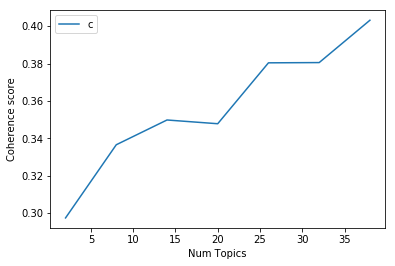

In [21]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Declaring the ```optimal_model``` as the previously generated ```ldamallet``` model.

In [22]:
optimal_model = ldamallet

Presenting the topics of the ```ldamallet``` model here.

In [23]:
model_topics = optimal_model.show_topics(formatted=False)

```num_words``` dictates the number of keywords to be presented with each topic.

In [24]:
pprint(optimal_model.print_topics(num_words=40))

[(0,
  '0.065*"disease" + 0.045*"increase" + 0.036*"transmission" + '
  '0.027*"potential" + 0.023*"forest" + 0.023*"suggest" + 0.017*"level" + '
  '0.016*"result" + 0.015*"incidence" + 0.015*"abundance" + 0.014*"important" '
  '+ 0.013*"nest" + 0.012*"rrv" + 0.012*"reduce" + 0.012*"landscape" + '
  '0.012*"ecological" + 0.012*"change" + 0.011*"ecosystem" + 0.010*"risk" + '
  '0.010*"examine" + 0.010*"emergence" + 0.009*"spatial" + 0.009*"include" + '
  '0.008*"tail" + 0.007*"function" + 0.007*"patch" + 0.007*"ground" + '
  '0.007*"prey" + 0.007*"predator" + 0.006*"hypothesis" + 0.006*"activity" + '
  '0.006*"leptospirosis" + 0.006*"highly" + 0.006*"australia" + 0.006*"period" '
  '+ 0.006*"maintain" + 0.006*"hantavirus" + 0.006*"long" + 0.006*"sleep" + '
  '0.006*"salinity"'),
 (1,
  '0.062*"study" + 0.041*"disease" + 0.039*"rat" + 0.035*"risk" + '
  '0.024*"urban" + 0.020*"factor" + 0.019*"capture" + 0.019*"include" + '
  '0.019*"population" + 0.018*"associate" + 0.018*"result" + 0.0

This function computes the dominant topic in each sentence. We use this meta-data as a part of our framework to understand under which areas of research do the publications fall in, and also to label each of the ```pyLDAvis``` topics.

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=textual_data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Generating the ```dataframes``` here which contains the dominant topics for each abstract.

In [26]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=textual_data)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.4130,"study, disease, rat, risk, urban, factor, incl...",[A seasonal rodent-borne disease surveillance ...
1,1,0.0,0.4812,"disease, increase, transmission, potential, fo...",[Alterations in transmission of vector-borne z...
2,2,4.0,0.2867,"sample, detect, study, positive, collect, spp,...",[Although the importance of rodents as reservo...
3,3,8.0,0.3372,"host, specie, vector, pathogen, important, fee...",[Amblyomma macula turn Koch is the primary vec...
4,4,5.0,0.1653,"tick, mammal, small, infection, number, nymph,...",[An inventory and monitoring program for speci...
5,5,11.0,0.4707,"virus, animal, mammal, wild, human, bear, anti...",[Avian influenza (AI) viruses primarily circul...
6,6,3.0,0.4732,"human, area, pattern, specie, mosquito, outbre...",[Background: Aedes albopictus is an invasive s...
7,7,3.0,0.4143,"human, area, pattern, specie, mosquito, outbre...",[Background: Mosquito-borne pathogens are of g...
8,8,0.0,0.3479,"disease, increase, transmission, potential, fo...",[Background: The two most reported mosquito-bo...
9,9,6.0,0.2503,"bat, community, dog, find, analysis, diversity...",[Bats are known reservoirs for numerous emergi...


Saving the ```dataframe``` to disc for analysis.

In [27]:
df_dominant_topic.to_csv(session_folder_name+'/Master_Topic_Per_Centence.csv')

Here we find the most representative document for each topic, and contain it in a ```dataframe``` and save it as a ```.csv```

In [28]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

In [30]:
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.head()
sent_topics_sorteddf_mallet['Number_Papers'] = [topic_counts[count] for count in range(num_topics)]
sent_topics_sorteddf_mallet['Percentage_Papers'] = [topic_contribution[count] for count in range(0, num_topics)]
sent_topics_sorteddf_mallet.to_csv(session_folder_name+'/Master_Topics_Contribution.csv')

Here, we find the number of documents for each topic.

In [31]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

In [32]:
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Number_Papers,Percentage_Papers
0,0.0,0.4812,"disease, increase, transmission, potential, fo...",[Alterations in transmission of vector-borne z...,11,0.0803
1,1.0,0.4465,"study, disease, rat, risk, urban, factor, incl...",[Norway rats (Rattus norvegicus) living in urb...,6,0.0438
2,2.0,0.5953,"population, specie, model, datum, effect, indi...",[Infectious disease introduced by non-native s...,9,0.0657
3,3.0,0.4732,"human, area, pattern, specie, mosquito, outbre...",[Background: Aedes albopictus is an invasive s...,9,0.0657
4,4.0,0.5059,"sample, detect, study, positive, collect, spp,...",[A number of parasitic diseases have gained im...,11,0.0803
5,5.0,0.4537,"tick, mammal, small, infection, number, nymph,...",[The ecology of Borrelia burgdorferi Johnson e...,17,0.1241
6,6.0,0.4716,"bat, community, dog, find, analysis, diversity...",[Eukaryotic microbes (protists) residing in th...,13,0.0949
7,7.0,0.5157,"reservoir, ecology, bartonella, region, transm...","[Background: Trypanosoma cruzi, the agent of C...",13,0.0949
8,8.0,0.4231,"host, specie, vector, pathogen, important, fee...",[We recovered larval trombiculid mites (i.e. c...,13,0.0949
9,9.0,0.4867,"plague, disease, year, colony, flea, show, hab...",[The characteristic striped appearance of zebr...,10,0.0730


Generating the visualization here from the ```lda_model```. We use this to label the broad areas of research, in syn which the representative documents generated above.

In [36]:
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

In [37]:
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)

/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Enabling the visualizations in the notebook here.

In [38]:
pyLDAvis.enable_notebook()

Saving the visualization to the disk, as an ```.html``` file in the sessions folder.

In [39]:
pyLDAvis.save_html(vis, session_folder_name+'/Master.html')

Presenting the ```pyLDAvis``` visualization here.

In [40]:
vis

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
0      8.903674        1       1 -0.272676 -0.026761
2      8.858200        1       2  0.035114 -0.037463
5      8.809525        1       3  0.207168 -0.202005
8      8.706057        1       4 -0.110592  0.158492
3      8.444182        1       5  0.072693  0.294235
4      8.374749        1       6  0.041282  0.083406
6      8.369232        1       7  0.096801 -0.076914
11     8.336801        1       8  0.237821  0.010771
10     8.327027        1       9 -0.027075 -0.238710
1      7.826665        1      10 -0.209159  0.059057
9      7.613583        1      11 -0.177904 -0.147327
7      7.430305        1      12  0.106526  0.123219, topic_info=     Category        Freq           Term       Total  loglift  logprob
1466  Default  261.000000           host  261.000000  30.0000  30.0000
2354  Default  242.000000         specie  242.000000  29.0000  29.0000
1775  Default  199.000000         mammal  199.000000  28.0000  28.0000
936   Default  224.000000        disease  224.000000  27.0000  27.0000
1194  Default  125.000000           tick  125.000000  26.0000  26.0000
458   Default  159.000000          human  159.000000  25.0000  25.0000
3549  Default  107.000000           high  107.000000  24.0000  24.0000
2436  Default  147.000000          study  147.000000  23.0000  23.0000
2357  Default  111.000000          small  111.000000  22.0000  22.0000
3191  Default   91.000000          virus   91.000000  21.0000  21.0000
251   Default  115.000000     population  115.000000  20.0000  20.0000
2379  Default   83.000000         animal   83.000000  19.0000  19.0000
1832  Default   73.000000           wild   73.000000  18.0000  18.0000
495   Default   72.000000       increase   72.000000  17.0000  17.0000
261   Default   77.000000         vector   77.000000  16.0000  16.0000
2656  Default   59.000000         plague   59.000000  15.0000  15.0000
2151  Default  107.000000       pathogen  107.000000  14.0000  14.0000
1658  Default   55.000000            rat   55.000000  13.0000  13.0000
1567  Default   73.000000         sample   73.000000  12.0000  12.0000
1102  Default   74.000000     prevalence   74.000000  11.0000  11.0000
2371  Default   65.000000           risk   65.000000  10.0000  10.0000
3386  Default   81.000000   transmission   81.000000   9.0000   9.0000
1578  Default   71.000000        suggest   71.000000   8.0000   8.0000
405   Default   68.000000           area   68.000000   7.0000   7.0000
173   Default   49.000000            bat   49.000000   6.0000   6.0000
1976  Default   62.000000      reservoir   62.000000   5.0000   5.0000
747   Default  107.000000      infection  107.000000   4.0000   4.0000
433   Default   46.000000        pattern   46.000000   3.0000   3.0000
1712  Default  100.000000         rodent  100.000000   2.0000   2.0000
1339  Default   43.000000           year   43.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
1028  Topic12   14.350197        complex   14.350197   2.5996  -4.5392
3274  Topic12   13.246336          world   13.246336   2.5996  -4.6192
75    Topic12   12.142474        lineage   12.142474   2.5996  -4.7062
164   Topic12   12.142474       southern   12.142474   2.5996  -4.7062
3159  Topic12    8.830890            tci    8.830890   2.5996  -5.0247
2700  Topic12    8.830890     biological    8.830890   2.5996  -5.0247
1418  Topic12    8.830890          point    8.830890   2.5996  -5.0247
1909  Topic12    8.830890         africa    8.830890   2.5996  -5.0247
311   Topic12    8.830890           sera    8.830890   2.5996  -5.0247
1980  Topic12    8.830890      elucidate    8.830890   2.5996  -5.0247
1958  Topic12    7.727029          broad    7.727029   2.5996  -5.1582
143   Topic12    7.727029      causative    7.727029   2.5996  -5.1582
1430  Topic12    7.727029       atlantic    7.727029   2.5996  -5.1582
1449  Topic12    6.6